# Notebook 04 – Neural Network Model

In [53]:
# %%
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier


Load data

In [54]:
data_path = r"C:/Users/USER/PycharmProjects/ML/data/Telco-Customer-Churn.csv"
df = pd.read_csv(data_path)


Data Cleaning

In [55]:
df = df.drop("customerID", axis=1)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


Load Preprocessor

In [56]:
preprocessor = joblib.load("results/preprocessor.pkl")
print("Preprocessor loaded successfully.")


Preprocessor loaded successfully.


Features

In [57]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_pre = preprocessor.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_pre, y, test_size=0.2, random_state=42, stratify=y
)


Apply SMOTE

In [58]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("SMOTE applied. New training shape:", X_train_res.shape)


SMOTE applied. New training shape: (8278, 45)


Build Neural Network Function

In [59]:
def build_nn(hidden_units=16, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_res.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


Wrap with KerasClassifier

In [60]:
keras_clf = KerasClassifier(
    model=build_nn,
    hidden_units=16,
    dropout_rate=0.2,
    learning_rate=0.001,
    epochs=50,
    batch_size=32,
    verbose=0,
    random_state=42
)


Hyperparameter Grid

In [61]:
param_dist = {
    "hidden_units": [16, 32, 64],
    "dropout_rate": [0.1, 0.2, 0.3],
    "batch_size": [16, 32],
    "epochs": [30, 50]
}


Randomized Search CV

In [62]:
rs_nn = RandomizedSearchCV(
    keras_clf,
    param_distributions=param_dist,
    n_iter=4,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42
)


Fit the Neural Network

In [63]:
rs_nn.fit(X_train_res, y_train_res)

print("Best NN parameters:", rs_nn.best_params_)
print("Best CV ROC AUC:", rs_nn.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, hidden_units=64; total time=  26.3s
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, hidden_units=64; total time=  21.0s
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, hidden_units=64; total time=  21.2s
[CV] END batch_size=16, dropout_rate=0.3, epochs=30, hidden_units=32; total time=  20.8s
[CV] END batch_size=16, dropout_rate=0.3, epochs=30, hidden_units=32; total time=  31.4s
[CV] END batch_size=16, dropout_rate=0.3, epochs=30, hidden_units=32; total time=  25.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=30, hidden_units=64; total time=  13.4s
[CV] END batch_size=32, dropout_rate=0.2, epochs=30, hidden_units=64; total time=  16.0s
[CV] END batch_size=32, dropout_rate=0.2, epochs=30, hidden_units=64; total time=  11.0s
[CV] END batch_size=32, dropout_rate=0.3, epochs=30, hidden_units=16; total time=  10.5s
[CV] END batch_size=32, dropout_rate=0.3, epochs=3

Evaluate on Test Set

Neural Network Accuracy: 0.7444996451383961

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81      1035
           1       0.51      0.71      0.59       374

    accuracy                           0.74      1409
   macro avg       0.70      0.73      0.70      1409
weighted avg       0.78      0.74      0.76      1409



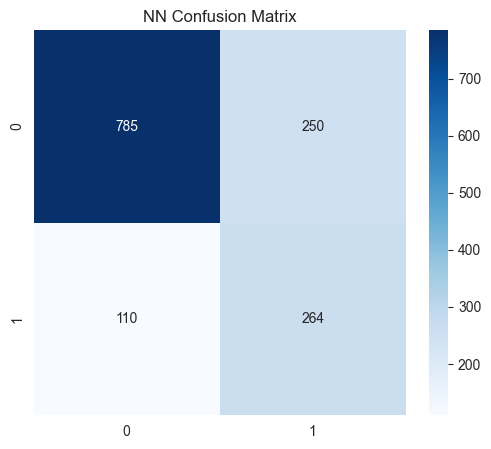

In [64]:
y_pred_nn = rs_nn.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int)

print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d', cmap='Blues')
plt.title("NN Confusion Matrix")
plt.show()


Save Model

In [65]:
joblib.dump(rs_nn.best_estimator_, "results/nn_model.pkl")
print("Neural Network model saved as nn_model.pkl")

Neural Network model saved as nn_model.pkl
